### Import packages

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
%matplotlib inline

In [4]:
df = pd.read_csv('df_clean.csv')

#### One hot encoding categorical variables

In [5]:
categorical_columns = ['SEX', 'EDUCATION', 'MARRIAGE']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

#### Set target variable

In [6]:
y = df_encoded['Y'].copy()
X = df_encoded.drop('Y', axis =1 ).copy()

#### Scale the data

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [9]:
X.columns

Index(['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_2', 'EDUCATION_2',
       'EDUCATION_3', 'EDUCATION_4', 'MARRIAGE_2', 'MARRIAGE_3'],
      dtype='object')

#### Data split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 100, shuffle=True)

####  RandomForest Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# set up parameters
rfc_metric = 'gini'
n_estimators = 100
random_state = 100

In [ ]:
# initialize the classifier
rfc = RandomForestClassifier(n_estimators= n_estimators,
                            random_state = random_state,
                            criterion = rfc_metric,
                            verbose=False)

In [ ]:
# train the model
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=100, verbose=False)

In [ ]:
# predict
rfc_pred = rfc.predict(X_test)

/tmp/ipykernel_24820/3209157109.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


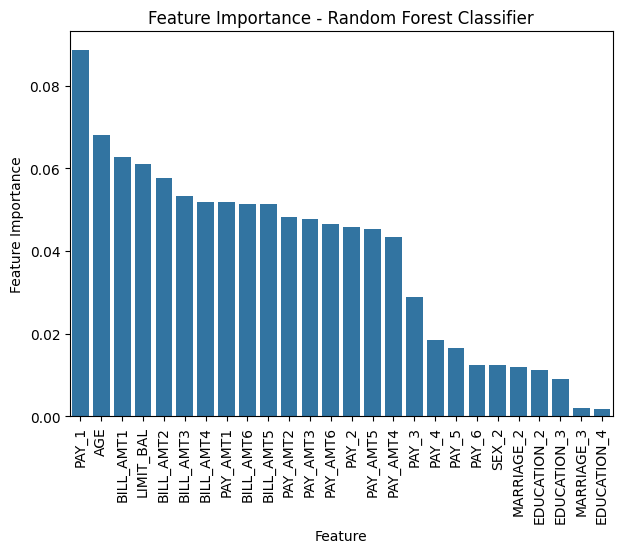

In [25]:
# feature importance
feature_df = pd.DataFrame({'Feature':X.columns, 'Feature Importance':rfc.feature_importances_})
feature_df = feature_df.sort_values(by = 'Feature Importance', ascending = False)
plt.figure(figsize=(7,5))
plt.title("Feature Importance - Random Forest Classifier")
s = sns.barplot(x = 'Feature', y ='Feature Importance', data = feature_df)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show()

Text(0.5, 1.0, 'Confusion Matrix - Random Forest Classifier')

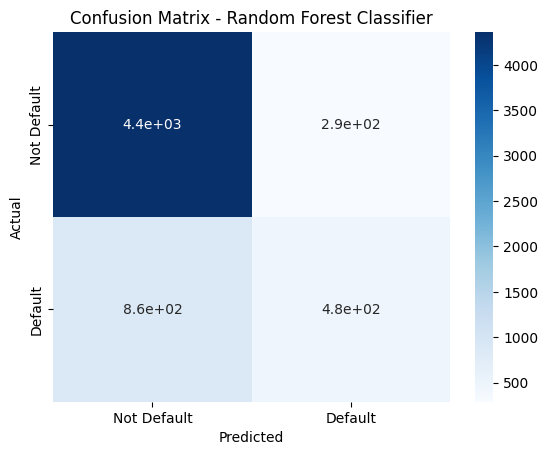

In [33]:
from sklearn.metrics import confusion_matrix

cm = pd.crosstab(y_test, rfc_pred, rownames = ['Actual'], colnames = ['Predicted'])
sns.heatmap(cm,
            xticklabels = ['Not Default', 'Default'],
            yticklabels = ['Not Default', 'Default'],
            annot = True,
            cmap='Blues')
plt.title("Confusion Matrix - Random Forest Classifier")

In [37]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, rfc_pred))
print(f"Area Under Curve:", roc_auc_score(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4650
           1       0.62      0.36      0.45      1343

    accuracy                           0.81      5993
   macro avg       0.73      0.65      0.67      5993
weighted avg       0.79      0.81      0.79      5993

Area Under Curve: 0.6468845226943369


#### Train the models: Logistic regression, Support vector machine, and Neural network.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [12]:
models = {
    LogisticRegression(): "Logistic Regression",
    SVC(): "Support Vector Machine",
    MLPClassifier(): "Neural Network"
}

for model in models.keys():
    model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


#### Evaluate the models: confusion matrix, AUC-ROC, F-1 Score.

In [13]:
for model, name in models.items():
    print(name + ": {:.2f}%".format(model.score(X_test, y_test)*100))

Logistic Regression: 81.59%
Support Vector Machine: 81.92%
Neural Network: 80.93%


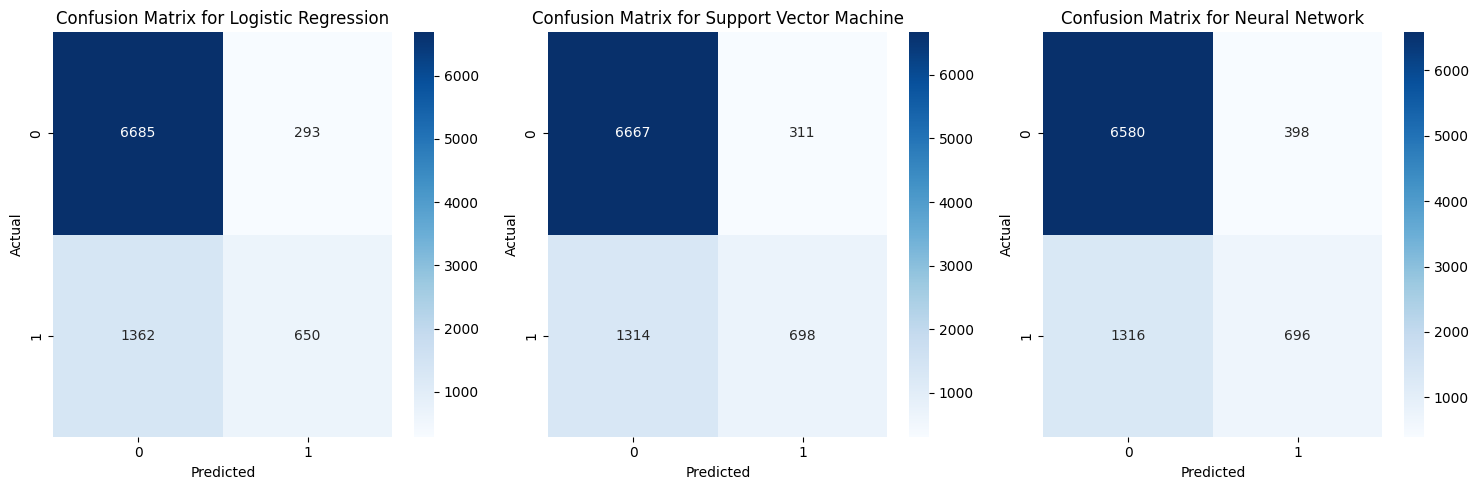

In [39]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (model, name) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

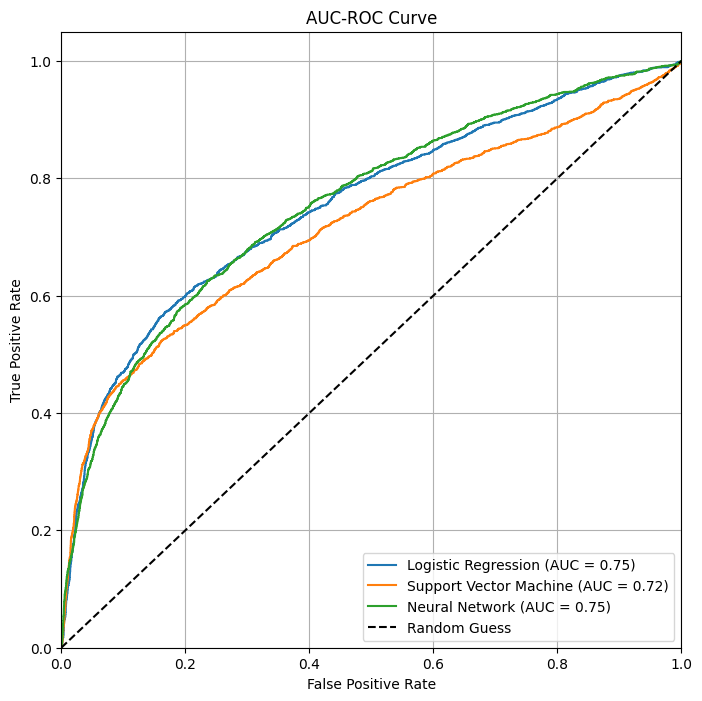

In [41]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 8))

for model, name in models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Recall: true positive. sensitivity. "Of all actual positives, how many were accurately identified?"

Precision: "Of all predicted positives, how many are actual positives?"

In credit default prediction, false negative is more costly given the nature of the business context. Therefore, measuring high recall is crucial. F-1 score measures both recall and precision, so it could be an efficient metric.

In [42]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

for model, name in models.items():
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"{name}:")
    print(f"  Recall: {recall:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Accuracy: {accuracy:.2f}")
    print(f"  F1 Score: {f1:.2f}")
    print()

Logistic Regression:
  Recall: 0.32
  Precision: 0.69
  Accuracy: 0.82
  F1 Score: 0.44

Support Vector Machine:
  Recall: 0.35
  Precision: 0.69
  Accuracy: 0.82
  F1 Score: 0.46

Neural Network:
  Recall: 0.35
  Precision: 0.64
  Accuracy: 0.81
  F1 Score: 0.45

